<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-David-Nicolas364/blob/main/Proyecto%3Afinal/Proyecto_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Proyecto capaz de detectar fake news

El objetivo de este código es que por medio del uso de redes neuronales sea capaz de aprender de nuetro conjunto de datos y por medio de una red neuronal se pueda detectar entre noticias verdaderas y noticias falsas. Este tipo de aprendizaje es supervisado ya que al programa se le dan noticias que ya se conocen como verdaderas o falsas y pasan por una red neuronal.

Table of contents:
  [imports]()

##Imports e installs

In [1]:
!pip install stop_words

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Datos obtenidos de: https://kaggle.com/competitions/fake-news.

# Procesado de datos

Dedibo a que los datos son texto lo primero que tenemos que hacer es cambiar los datos a número para que así se pueda entender en el programa y puedan ser usados en la red neuronal

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Cosas ML/train_set.csv/train.csv")

In [4]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


En este dataframe se presenta una identificación para cada noticia, así como: el título del artículo, el autor, el texto, además para este dataset se nos presenta si las noticias son verdaderas si en label contienen un 0 y es falsa si contiene un 1

In [5]:
df.shape

(20800, 5)

Verificamos que en nuestros datos no hayan datos vacios

In [6]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

Eliminamos estos renglones con datos faltantes

In [7]:
dat = df.dropna()

In [8]:
dat.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [9]:
dat.shape

(18285, 5)

El siguiente paso es la eliminación de palabras que no nos aporten nada en el análisis del texto usando la librería stop_word, además de otros caracteres que no sean alfanuméricos fuera de las palabras

Las stopwords son:

In [10]:
stop_words = get_stop_words("en")
punctuations = "'!()-[]{};:',#$%&/=?´+@^`~\*.-"
def quitar_palabras(texto):
  palabras = texto.split()
  palabras_buenas =[]
  for i in range(len(palabras)):
    if palabras[i] not in stop_words and palabras[i] not in punctuations:
      palabras_buenas.append(palabras[i])
  good_words = ' '.join(palabras_buenas)
  return good_words

Se usa la librería re, que su uso principal es para la identificación de tipos de caracterés, en este caso uso \d para números \W para caracterés no alfanúmericos dentro de las palabras

In [11]:
def limpiar(cuerpo):
  #se usa re.compile para tener un tipo de patrón
  #en este se encuentran números
  patron = re.compile('\d' )
  #aquí se encuentra carácteres no alfanúmericos
  patron2 = re.compile('\W' )
  #se cambian a minúsculas
  cuerpo = cuerpo.lower()
  #Se sustituyen los carácteres del patrón1
  cuerpo = patron.sub('', cuerpo)
  #Se sustituyen los carácteres del patrón2
  cuerpo = patron2.sub(' ', cuerpo)
  #Se utilliza la función anterior para quitar stop-words y carácteres no alfanuméricos
  cuerpo = quitar_palabras(cuerpo)
  return cuerpo

Se crea otra columna que contenga el texto ya limpio de los artículos

In [12]:
dat['limpio'] = dat.text.map(lambda x: limpiar(x))

<ipython-input-12-2708f10d460e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['limpio'] = dat.text.map(lambda x: limpiar(x))


In [13]:
dat

,id,title,author,text,label,limpio
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didn t even see comey s letter ...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed single us airstrike id...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,rapper t unloaded black celebrities met donald...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,green bay packers lost washington redskins wee...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,macy s today grew union several great names am...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,nato russia hold parallel exercises balkans pr...


Para reducir aún más el número de palabras usaremos el proceso stemming que lo que realizará es la reducción de palabras a su raíz, por ejemplo:
actor, actriz, actuar -> acto

In [14]:
port_stem = PorterStemmer()

In [15]:
def stemming(contenido):
  stemmed_contenido = contenido.split()
  stemmed_contenido = [port_stem.stem(word) for word in stemmed_contenido]
  stemmed_contenido = ' '.join(stemmed_contenido)
  return stemmed_contenido

In [16]:
dat['limpio'] = dat['limpio'].apply(stemming)

<ipython-input-16-15422f8e2b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat['limpio'] = dat['limpio'].apply(stemming)


In [17]:
corpus = dat.limpio.values

El siguiente paso es convertir cada texto en una lista, se usará la paquetería nltk y la función TweetTokenizer

In [18]:
tknzr=TweetTokenizer()
tknzr.tokenize(corpus[0])

['hous',
 'dem',
 'aid',
 'didn',
 't',
 'even',
 'see',
 'comey',
 's',
 'letter',
 'jason',
 'chaffetz',
 'tweet',
 'darrel',
 'lucu',
 'octob',
 'subscrib',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'imag',
 'courtesi',
 'michael',
 'jolley',
 'avail',
 'creativ',
 'common',
 'licens',
 'apolog',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'week',
 'fbi',
 'director',
 'jame',
 'comey',
 'accord',
 'hous',
 'democrat',
 'aid',
 'look',
 'like',
 'also',
 'know',
 'second',
 'worst',
 'person',
 'well',
 'turn',
 'comey',
 'sent',
 'now',
 'infam',
 'letter',
 'announc',
 'fbi',
 'look',
 'email',
 'may',
 'relat',
 'hillari',
 'clinton',
 's',
 'email',
 'server',
 'rank',
 'democrat',
 'relev',
 'committe',
 'didn',
 't',
 'hear',
 'comey',
 'found',
 'via',
 'tweet',
 'one',
 'republican',
 'committe',
 'chairmen',
 'now',
 'know',
 'comey',
 'notifi',
 'republican',
 'chairmen',
 'democrat',
 'rank',
 'member',
 'hous',
 'intellig',
 '

Se usa un ciclo for para realizarlo en cada texto

In [19]:
corpus_tk=[]
for i in corpus:
  corpus_tk.append(tknzr.tokenize(i))

El siguiente paso es convertir cada palabra a una representación vectorial esto se hace por un método llamado Word2Vec en la cual a una palabra se le da un vector y cada palabra se puede relacionar a otra similar por medio de suma o resta vectorial.

In [20]:
#Se da la entrada de los textos a representar, en min_count es la cantidad necesaria a repetirse una palabra para tomarse en cuenta
#En window es una ventana de contexto
#size representa el tamaño del vector de cada palabra
model = Word2Vec(corpus_tk, min_count=50, window = 5, vector_size=100)

In [21]:
X = model.wv.vectors

In [22]:
X.shape

(10246, 100)

Vamos a reducir la dimensionalidad del modelo de Word2Vec ya que al tener más componentes va a ser más complejo este en la red neuronal

Usaremos PCA para reducir los componentes de los vectores, en el gráfico se presenta el porcentaje de varianza que se perderá en función al número de componentes principales

Text(0.5, 0, 'PCA Componentes')

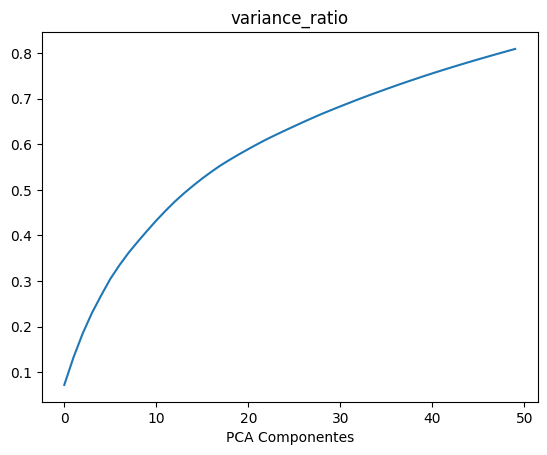

In [23]:
pca = PCA(n_components=50, svd_solver='full')
pca.fit(X)
plt.plot((pca.explained_variance_ratio_).cumsum())
plt.title('variance_ratio')
plt.xlabel('PCA Componentes')

Se puede observar que con 30 componentes se queda con el 70% de la varianza que parece ser un buen punto para no tener mucha complejidad

In [24]:
pca = PCA(n_components=30, svd_solver='full')
pca.fit(X)

PCA(n_components=30, svd_solver='full')

Con lo que obtenemos una representación vectorial de cada palabra de 30 componentes

Para convertir un texto en su representación numérica lo que haremos calcular la media entre la representación numérica de cada palabra y lo que nos salga es la representación vectorial del texto

In [25]:
vectorizer = TfidfVectorizer(min_df=30)
TF_IDF=vectorizer.fit_transform(corpus)

In [26]:
TF_IDF.toarray().shape

(18285, 10927)

Se guardará la posición de cada palabra

In [27]:
tf_idf=vectorizer.vocabulary_

In [28]:
tf_idf['freedom']

3810

In [29]:
TF_IDF[0, tf_idf['freedom']]

0.0

In [30]:
X.shape

(10246, 100)

In [31]:
corpus[0].split(' ')

['hous',
 'dem',
 'aid',
 'didn',
 't',
 'even',
 'see',
 'comey',
 's',
 'letter',
 'jason',
 'chaffetz',
 'tweet',
 'darrel',
 'lucu',
 'octob',
 'subscrib',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'imag',
 'courtesi',
 'michael',
 'jolley',
 'avail',
 'creativ',
 'common',
 'licens',
 'apolog',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'week',
 'fbi',
 'director',
 'jame',
 'comey',
 'accord',
 'hous',
 'democrat',
 'aid',
 'look',
 'like',
 'also',
 'know',
 'second',
 'worst',
 'person',
 'well',
 'turn',
 'comey',
 'sent',
 'now',
 'infam',
 'letter',
 'announc',
 'fbi',
 'look',
 'email',
 'may',
 'relat',
 'hillari',
 'clinton',
 's',
 'email',
 'server',
 'rank',
 'democrat',
 'relev',
 'committe',
 'didn',
 't',
 'hear',
 'comey',
 'found',
 'via',
 'tweet',
 'one',
 'republican',
 'committe',
 'chairmen',
 'now',
 'know',
 'comey',
 'notifi',
 'republican',
 'chairmen',
 'democrat',
 'rank',
 'member',
 'hous',
 'intellig',
 '

Se creará un array de la representación numérica de cada noticia

In [32]:
x=np.zeros((dat.shape[0],30))
for i,corp in enumerate(corpus):
  vect = np.zeros(100)
  for num,word in enumerate(corp.split(' ')):
    try:
      vect+=model.wv[word]*TF_IDF[i,tf_idf[word]]
    except:
        pass
  if num!=0:
     vect=vect/num
  else:
      vect=vect*0
  vect=vect.reshape(1,100)
  vect_pca=pca.transform(vect)
  x[i,:] = vect_pca

In [33]:
model

In [34]:
model.wv['hous']*TF_IDF[i,tf_idf['hous']] +model.wv['email']*TF_IDF[i,tf_idf['email']]

array([-0.02658584, -0.18381885, -0.0544737 ,  0.0198129 , -0.10402332,
        0.01004201, -0.03333048,  0.04854736, -0.01059467,  0.08211416,
        0.21874323, -0.04432273,  0.02226654,  0.07966419, -0.13829188,
       -0.01689285,  0.02522256,  0.02385174, -0.06096153,  0.10052948,
        0.09283482, -0.1276231 ,  0.00433867,  0.11206315,  0.05254607,
       -0.05438417,  0.0478726 ,  0.02205273, -0.03686892, -0.00414799,
        0.06808697,  0.16969018, -0.0450829 ,  0.02678221, -0.01649553,
       -0.02990444,  0.00891045,  0.05657113,  0.03861392,  0.09362694,
        0.1255231 ,  0.02320699,  0.01701214,  0.05014506, -0.04435093,
        0.02598468, -0.03239254,  0.02016114,  0.14435406,  0.01818715,
       -0.0510228 ,  0.03052844,  0.1148803 , -0.09116289,  0.08775877,
        0.03079541, -0.03768476,  0.05173916,  0.10948306,  0.06622   ,
        0.01625424, -0.09261326,  0.08417284, -0.1283255 , -0.12239843,
       -0.00295572, -0.04029753,  0.04118957, -0.07832833,  0.00

In [35]:
x

array([[ 0.41314847,  0.407678  , -0.18144944, ..., -0.03332257,
        -0.04722867,  0.05832228],
       [ 0.41910753,  0.25049806, -0.1979712 , ..., -0.02186222,
        -0.00679601,  0.06805385],
       [ 0.49678224,  0.25132501, -0.09420724, ..., -0.0511062 ,
        -0.00621295,  0.05732848],
       ...,
       [ 0.29408482,  0.16773414,  0.02274946, ...,  0.00088476,
        -0.04020446,  0.08009413],
       [ 0.65688323,  0.29615113,  0.10517302, ...,  0.01605698,
         0.04491554,  0.09065122],
       [ 0.37993114,  0.23505842, -0.07755281, ..., -0.03689967,
        -0.0125135 ,  0.08512548]])

In [36]:
Y = dat['label'].values

In [37]:
Y.shape

(18285,)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, stratify=Y, random_state=2)

In [39]:
x_train

array([[ 0.39833273,  0.12728128, -0.07941898, ..., -0.04682483,
        -0.01169362,  0.07699199],
       [ 0.36212256,  0.20833167, -0.04332417, ..., -0.02735842,
        -0.03685475,  0.07775874],
       [ 0.30767703,  0.38465742, -0.17674158, ..., -0.01254051,
        -0.05800662,  0.02977494],
       ...,
       [ 0.27732505,  0.19297121, -0.07410175, ..., -0.04004616,
         0.14931014,  0.10016099],
       [ 0.38054235,  0.18990717, -0.05737035, ..., -0.03004442,
        -0.01215775,  0.06721466],
       [ 0.27612348,  0.16483218, -0.10137404, ..., -0.01985905,
         0.0032591 ,  0.07627616]])

In [40]:
x_test

array([[ 0.72761506,  0.21656712, -0.14785697, ..., -0.03663021,
        -0.09868047,  0.03823733],
       [ 0.75281782,  0.45954775, -0.03093452, ...,  0.00279579,
         0.00270493,  0.00854019],
       [ 0.31383953,  0.41725179,  0.00834511, ...,  0.051767  ,
        -0.00492899, -0.01151945],
       ...,
       [ 0.57050427,  0.51964853, -0.09472599, ..., -0.03263345,
         0.0089673 ,  0.0635275 ],
       [ 0.38745408,  0.52536479, -0.1357112 , ..., -0.00713745,
         0.00288973,  0.10798493],
       [ 0.63845368,  0.3877685 , -0.10598608, ..., -0.00104429,
         0.02491707,  0.04620772]])

Normalización

In [41]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [42]:
x_test

array([[ 1.61283359e+00, -4.13398095e-01, -3.26903419e-01, ...,
        -2.98969247e-01, -1.38409896e+00, -4.92282060e-01],
       [ 1.74598051e+00,  1.23017803e+00,  5.87882402e-01, ...,
         4.45238352e-01,  2.51372643e-01, -1.08443404e+00],
       [-5.73154532e-01,  9.44078578e-01,  8.95201071e-01, ...,
         1.36962200e+00,  1.28228052e-01, -1.48441721e+00],
       ...,
       [ 7.82812717e-01,  1.63671336e+00,  8.87863697e-02, ...,
        -2.23526194e-01,  3.52392424e-01,  1.19962222e-02],
       [-1.84246726e-01,  1.67537941e+00, -2.31876511e-01, ...,
         2.57737956e-01,  2.54353582e-01,  8.98463932e-01],
       [ 1.14179143e+00,  7.44646914e-01,  6.88851905e-04, ...,
         3.72752747e-01,  6.09681827e-01, -3.33354862e-01]])

In [43]:
print(Y)

[1 0 1 ... 0 1 1]


# Modelo de Machine learning

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

Modelo 1 (3 capas ocultas

In [45]:
tf.random.set_seed(1234)
model = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [46]:
model.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [47]:
historial = model.fit(x_train, y_train, epochs = 50)

Epoch 1/50
458/458 [==============================] - 1s 2ms/step - loss: 0.5933 - accuracy: 0.7196
Epoch 2/50
458/458 [==============================] - 1s 2ms/step - loss: 0.4629 - accuracy: 0.8007
Epoch 3/50
458/458 [==============================] - 1s 2ms/step - loss: 0.4125 - accuracy: 0.8188
Epoch 4/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3888 - accuracy: 0.8303
Epoch 5/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3726 - accuracy: 0.8422
Epoch 6/50
458/458 [==============================] - 1s 1ms/step - loss: 0.3599 - accuracy: 0.8494
Epoch 7/50
458/458 [==============================] - 1s 1ms/step - loss: 0.3499 - accuracy: 0.8549
Epoch 8/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3412 - accuracy: 0.8592
Epoch 9/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3335 - accuracy: 0.8616
Epoch 10/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3262 - accuracy: 0.8645

In [48]:
cost, ac = model.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 0s 1ms/step - loss: 0.3441 - accuracy: 0.8660
Cost: 0.3441498279571533, Accuracy: 0.8660103678703308


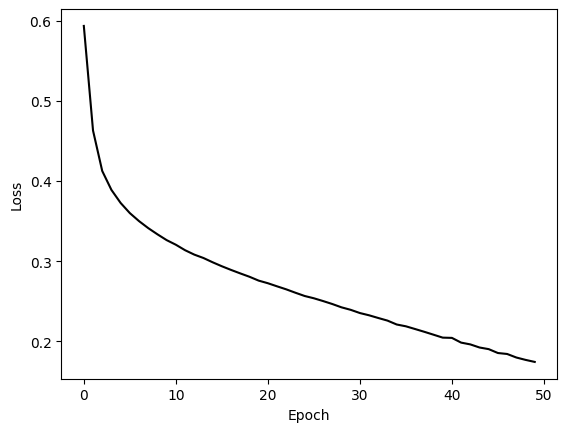

In [49]:
plt.plot(historial.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Modelo 2( 2 capas ocultas de 500 neuronas)

In [51]:
tf.random.set_seed(1234)
model2 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(500, activation='relu'),
  Dense(500, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [52]:
model2.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [53]:
historial2 = model2.fit(x_train, y_train, epochs = 50)

Epoch 1/50
458/458 [==============================] - 3s 5ms/step - loss: 0.5734 - accuracy: 0.7512
Epoch 2/50
458/458 [==============================] - 2s 3ms/step - loss: 0.4557 - accuracy: 0.8080
Epoch 3/50
458/458 [==============================] - 1s 3ms/step - loss: 0.4137 - accuracy: 0.8214
Epoch 4/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3933 - accuracy: 0.8298
Epoch 5/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3794 - accuracy: 0.8367
Epoch 6/50
458/458 [==============================] - 2s 4ms/step - loss: 0.3688 - accuracy: 0.8415
Epoch 7/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3607 - accuracy: 0.8486
Epoch 8/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3532 - accuracy: 0.8505
Epoch 9/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3465 - accuracy: 0.8547
Epoch 10/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3405 - accuracy: 0.8582

In [54]:
cost, ac = model2.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 1s 7ms/step - loss: 0.3275 - accuracy: 0.8646
Cost: 0.32748329639434814, Accuracy: 0.8646431565284729


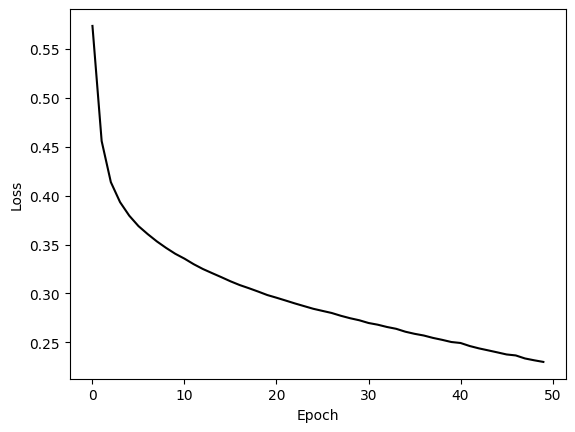

In [55]:
plt.plot(historial2.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Modelo 3 (5 capas ocultas de 200' neuronas)

In [57]:
tf.random.set_seed(1234)
model3 = Sequential([
  tf.keras.Input(shape=(x_train.shape[1])),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(200, activation='relu'),
  Dense(1,activation='sigmoid')
])

In [58]:
model3.compile(optimizer='sgd', loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [59]:
historial3 = model3.fit(x_train, y_train, epochs = 50)

Epoch 1/50
458/458 [==============================] - 2s 4ms/step - loss: 0.6404 - accuracy: 0.6596
Epoch 2/50
458/458 [==============================] - 1s 3ms/step - loss: 0.4733 - accuracy: 0.7914
Epoch 3/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3981 - accuracy: 0.8278
Epoch 4/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3710 - accuracy: 0.8440
Epoch 5/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3521 - accuracy: 0.8514
Epoch 6/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3366 - accuracy: 0.8594
Epoch 7/50
458/458 [==============================] - 1s 2ms/step - loss: 0.3240 - accuracy: 0.8677
Epoch 8/50
458/458 [==============================] - 1s 3ms/step - loss: 0.3139 - accuracy: 0.8692
Epoch 9/50
458/458 [==============================] - 2s 4ms/step - loss: 0.3037 - accuracy: 0.8756
Epoch 10/50
458/458 [==============================] - 1s 2ms/step - loss: 0.2949 - accuracy: 0.8790

In [60]:
cost, ac = model3.evaluate(x_test, y_test)

print('Cost: {}, Accuracy: {}'.format(cost, ac))

115/115 [==============================] - 1s 5ms/step - loss: 0.4756 - accuracy: 0.8611
Cost: 0.4756406247615814, Accuracy: 0.8610883355140686


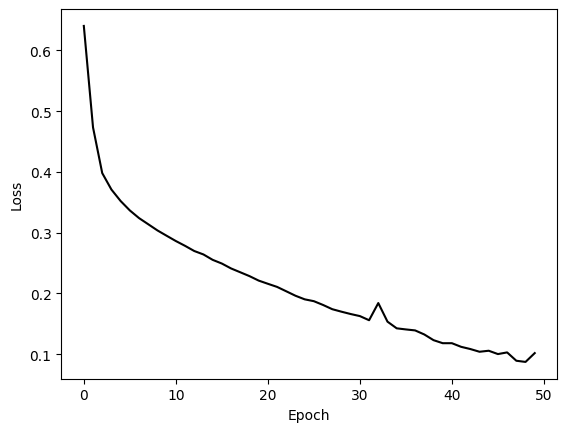

In [61]:
plt.plot(historial3.history['loss'], color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()